# 相对强弱市场
*强者越强，弱者越弱*

## 目录
1. 什么是相对强弱？
2. 怎么计算相对强弱？
3. 如何用图形展示相对强弱？
4. 如何用相对强弱来编写策略？

## 什么是相对强弱？
一段时间内某股票和本行业的股票或整个市场的比较，即对该股票市场表现的计量。

## 怎么计算相对强弱？
RS = Stock/Index

MOM_RS = Momentum(RS)

MOM_MOM = Momentum(MOM_RS)

## 如何用图形展示相对强弱？

In [1]:
from jaqs.data import DataView
from jaqs.data import RemoteDataService
import os
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

dataview_folder = '../JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [2]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df
stock = change_index(dv.get_ts('close_adj').loc[20170105:])
hs300 = change_index(dv.data_benchmark.loc[20170105:])

In [3]:
RS = stock['600036.SH']/hs300.close
RS = RS.dropna()
print (RS.tail())

2017-12-18    0.009375
2017-12-19    0.009595
2017-12-20    0.009642
2017-12-21    0.009609
2017-12-22    0.009527
dtype: float64


In [4]:
#Momentum_RS
import talib as ta

MOM_RS = ta.ROCR100(RS.values, 20)
MOM_MOM = ta.ROCR100(MOM_RS, 20)
data_s = stock['600036.SH']
data1 = pd.Series(MOM_RS, index=RS.index)
data2 = pd.Series(MOM_MOM, index=RS.index)
data = pd.concat([data_s, RS, data1, data2], axis=1)
data.columns = ['close', 'RS', 'MOM_RS', 'MOM_MOM']
print (data.tail())

                close        RS      MOM_RS    MOM_MOM
2017-12-18  37.360561  0.009375   96.485483  88.288186
2017-12-19  38.718887  0.009595  101.076718  94.407043
2017-12-20  38.863951  0.009642  100.035532  92.229752
2017-12-21  39.088141  0.009609   99.639105  90.583452
2017-12-22  38.626574  0.009527   98.532208  93.897203


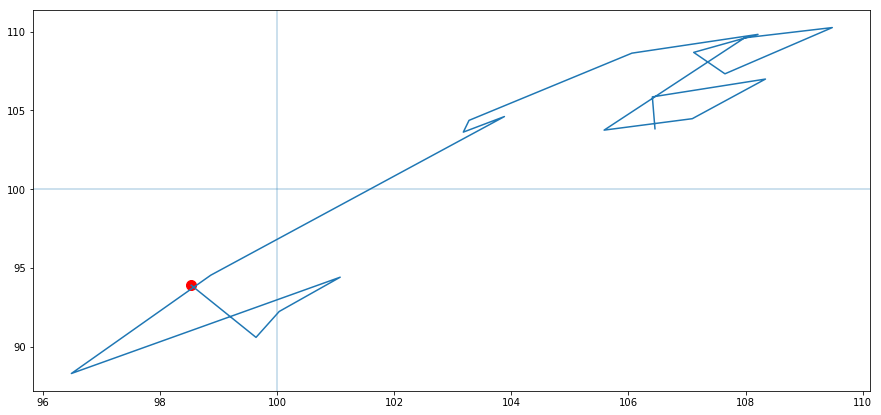

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(data.MOM_RS.tail(20).values, data.MOM_MOM.tail(20).values)
plt.axhline(100,alpha=0.3)
plt.axvline(100,alpha=0.3)
X=data['MOM_RS'].iloc[-1]
Y=data['MOM_MOM'].iloc[-1]
plt.scatter(X,Y,color='r', s=100)
plt.show()

## 如何用相对强弱来编写策略？
**买入时机：**

第一象限：（MOM_RS>100, MOM_MOM>100）

第四象限：（MOM_RS< 100, MOM_MOM >100）

**卖出时机**

第二象限：（MOM_RS > 100, MOM_MOM < 100）

第三象限：（MOM_RS< 100, MOM_MOM < 100）

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


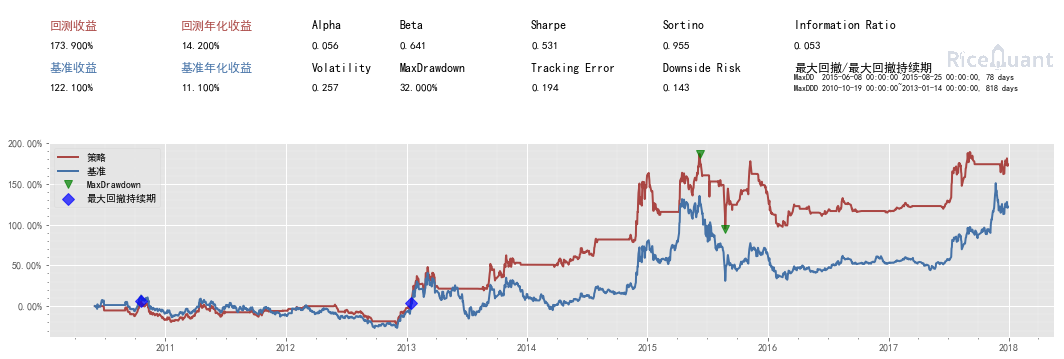

{'sys_analyser': {'benchmark_portfolio':                  cash  market_value  static_unit_net_value  total_value  \
  date                                                                      
  2010-06-01      8.100    999991.900                  1.000  1000000.000   
  2010-06-02      8.100    995945.690                  1.000   995953.790   
  2010-06-03      8.100    995367.660                  0.996   995375.760   
  2010-06-04      8.100    999991.900                  0.995  1000000.000   
  2010-06-07      8.100    977448.730                  1.000   977456.830   
  2010-06-08      8.100    965310.100                  0.977   965318.200   
  2010-06-09      8.100   1021379.010                  0.965  1021387.110   
  2010-06-10      8.100    989009.330                  1.021   989017.430   
  2010-06-11      8.100    991321.450                  0.989   991329.550   
  2010-06-17      8.100    991321.450                  0.991   991329.550   
  2010-06-18      8.100   1001147.960

In [6]:
#Relative_Strength

import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.index = "000300.XSHG"
    context.PERIOD = 50
    
def handle_bar(context, bar_dict):
    price = history_bars(context.s1, context.PERIOD*3, '1d', 'close')
    index = history_bars(context.index, context.PERIOD*3, '1d', 'close')
    
    if len(price)==len(index):
        RS = price/index
        MOM = talib.ROCR100(RS, context.PERIOD)
        if len(MOM)>context.PERIOD:
            MOM_MOM = talib.ROCR100(MOM, context.PERIOD)
            cur_position = context.portfolio.positions[context.s1].quantity
            shares = context.portfolio.cash/bar_dict[context.s1].close

            if (MOM_MOM[-1]<100) and (MOM_MOM[-2]>100):
                order_target_value(context.s1, 0)

            if (MOM_MOM[-1]>100) and (MOM_MOM[-2]<100) and (cur_position==0):
                order_shares(context.s1, shares)
        
config = {
  "base": {
    "start_date": "2010-06-01",
    "end_date": "2017-12-30",
    "accounts": {'stock':1000000},
    "benchmark": "000001.XSHE"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

## 作业
根据以上代码做出其他象限进场的策略